## 0. Problem Statement

The objective of this project is to build a **price recommendation system** for an
online used-car marketplace.

Given information about a vehicle **available at the time of listing**, the system
recommends a reasonable **listing price** to sellers. The goal is to learn market
pricing patterns from historical listings and provide data-driven price suggestions.

### Target
- **price**: the listing price of the vehicle

### Intended user
- Sellers on an online used-car marketplace (via the platform)

### Modeling constraints
- Only features available **before the listing goes live** may be used
- Post-listing outcomes and platform interaction signals are excluded
- Data freshness matters due to market dynamics

### Evaluation metrics
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)

## 1. Feature Availabilty & Leakage Audit

**Decision point:** Price recommendation at listing time.

Only information available before the seller sets the listing price may be used
as model input features.

**Blocking rule:**  
Any column whose value is not available at listing time, or is a consequence of
buyer interaction or platform behavior, is excluded from modeling.

**Default rule:**  
If availability is unclear, the column is marked as *Review later* until explicitly
justified.

In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/vehicles.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

In [3]:
df.isna().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
image_url           68
description         70
county          426880
state                0
lat               6549
long              6549
posting_date        68
dtype: int64

| Column Name    | Status        | Reason |
|---------------|---------------|--------|
| price         | Target        | Listing price to be predicted |
| id            | Blocked       | Unique identifier, no generalizable pricing signal |
| url           | Blocked       | Platform identifier, no causal relation to price |
| region        | Allowed       | Broad geographic market context, known before listing |
| region_url    | Blocked       | Platform-specific URL, not a pricing attribute |
| year          | Allowed       | Vehicle age, a core causal driver of price |
| manufacturer  | Allowed       | Brand information known before listing |
| model         | Allowed       | Model-level differentiation affecting price |
| condition     | Allowed       | Seller-reported vehicle condition, known at listing |
| cylinders     | Allowed       | Engine specification, intrinsic to the car |
| fuel          | Allowed       | Fuel type, known before listing |
| odometer      | Allowed       | Vehicle usage, directly influences price |
| title_status  | Review later  | Legal status affects price but definitions may be inconsistent |
| transmission  | Allowed       | Vehicle specification known before listing |
| VIN           | Blocked       | Unique identifier, high cardinality, memorization risk |
| drive         | Allowed       | Drivetrain specification, intrinsic attribute |
| size          | Allowed       | Vehicle size category, affects pricing |
| type          | Allowed       | Vehicle body type, known before listing |
| paint_color   | Allowed       | Cosmetic attribute known at listing |
| image_url     | Blocked       | Platform artifact, no pricing signal |
| description   | Review later  | Free-text may encode seller intent or pricing language |
| county        | Blocked       | No usable data (all values missing) |
| state         | Allowed       | Coarse location signal known before listing |
| lat           | Allowed       | Geographic proxy for local market |
| long          | Allowed       | Geographic proxy for local market |
| posting_date  | Review later  | Can enable listing duration / market response leakage |

## 2. Target (`Price`) Analysis & Cleaning

### 2.1 Price Scale and Range

In [4]:
# Summary statistics for target variable: price

price_stats = df["price"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
price_stats

count    4.268800e+05
mean     7.519903e+04
std      1.218228e+07
min      0.000000e+00
5%       0.000000e+00
25%      5.900000e+03
50%      1.395000e+04
75%      2.648575e+04
95%      4.450000e+04
max      3.736929e+09
Name: price, dtype: float64

**Observations:**
- The median listing price is approximately 14k, while the mean is significantly higher, indicating a strongly right-skewed distribution.
- At least 5% of listings have a price of zero, suggesting missing or placeholder values.
- Extreme outliers exist (maximum price in the billions), which are likely data errors and heavily inflate variance.
- Most listings (95%) are priced below ~45k, indicating a relatively compact typical price range.

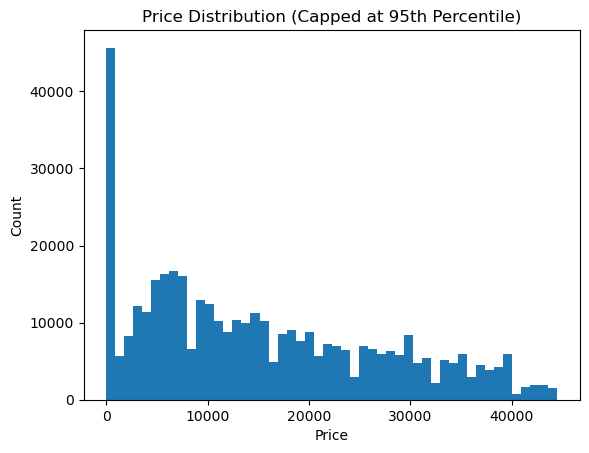

In [5]:
import matplotlib.pyplot as plt

# Cap price at 95th percentile for visualization
upper_bound = df["price"].quantile(0.95)
price_capped = df.loc[df["price"] <= upper_bound, "price"]

plt.figure()
plt.hist(price_capped, bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution (Capped at 95th Percentile)")
plt.show()

**Distribution shape:**
- Even after capping extreme values at the 95th percentile, the price distribution
  remains strongly right-skewed with a long tail.
- This suggests that a log transformation of the target may be beneficial for
  stabilizing variance and improving model performance.
- However, a non-trivial fraction of listings have zero-valued prices, which must
  be addressed during data cleaning before applying any log transformation.

## 2.2 Invalid Target Entries: Zero-Priced Listings

In [6]:
df_clean = df.copy()

In [7]:
zero_price_df = df_clean[df_clean["price"] == 0]
valid_price_df = df_clean[df_clean["price"] > 0]

len(zero_price_df), len(valid_price_df)

(32895, 393985)

In [8]:
zero_price_df["manufacturer"].value_counts(normalize=True).head(10)

manufacturer
ford             0.195012
chevrolet        0.140644
toyota           0.082777
ram              0.059744
nissan           0.053191
jeep             0.049405
honda            0.044601
mercedes-benz    0.043106
gmc              0.043074
dodge            0.042565
Name: proportion, dtype: float64

In [9]:
valid_price_df["manufacturer"].value_counts(normalize=True).head(10)

manufacturer
ford         0.171665
chevrolet    0.134047
toyota       0.083642
honda        0.052586
jeep         0.046218
nissan       0.046043
ram          0.043579
gmc          0.040844
bmw          0.036382
dodge        0.032740
Name: proportion, dtype: float64

In [10]:
zero_missing_pct = zero_price_df.isna().mean().sort_values(ascending=False)
valid_missing_pct = valid_price_df.isna().mean().sort_values(ascending=False)

zero_missing_pct.head(10), valid_missing_pct.head(10)

(county         1.000000
 size           0.712206
 condition      0.690530
 cylinders      0.524943
 paint_color    0.396838
 drive          0.313513
 VIN            0.270071
 type           0.210549
 long           0.093023
 lat            0.093023
 dtype: float64,
 county          1.000000
 size            0.718131
 cylinders       0.407147
 VIN             0.386203
 condition       0.384251
 drive           0.305225
 paint_color     0.297344
 type            0.218110
 manufacturer    0.041080
 title_status    0.019630
 dtype: float64)

**Observations:**
- ~5% listings had price = 0
- Treated as invalid targets (not true prices)
- Inspected manufacturer distribution and missingness
- No distinct structure found → safely removed

### 2.3 Extreme Price Outliers

In [11]:
df_clean = df_clean[df_clean["price"] > 0].reset_index(drop=True)
df_clean["price"].min(), len(df_clean)

(1, 393985)

In [12]:
upper_price_cutoff = df_clean["price"].quantile(0.995)
upper_price_cutoff

np.float64(78900.0)

In [13]:
df_clean = df_clean[df_clean["price"] <= upper_price_cutoff].reset_index(drop=True)

In [14]:
df_clean["price"].describe()

count    392020.000000
mean      18491.886797
std       14010.701574
min           1.000000
25%        7000.000000
50%       15000.000000
75%       27421.000000
max       78900.000000
Name: price, dtype: float64

**Observations:**
- Extremely large prices observed (up to billions)
- Used percentile-based cutoff (99.5th percentile ≈ 78.9k)
- Removed top 0.5% as likely data errors
- Retained plausible luxury vehicles

### 2.4 Log Transformation of Target

In [15]:
import numpy as np

df_clean["log_price"] = np.log(df_clean["price"])
df_clean[["price", "log_price"]].describe()

,price,log_price
count,392020.000000,392020.000000
mean,18491.886797,9.399119
std,14010.701574,1.248788
min,1.000000,0.000000
25%,7000.000000,8.853665
50%,15000.000000,9.615805
75%,27421.000000,10.219064
max,78900.000000,11.275937


**Observations:**
- Applied log transform to reduce skew
- Improves model stability and learning
- Original price retained for inverse transformation

In [16]:
# NOTE:
# This file is generated once and intentionally not overwritten on every run.
# Uncomment only if target preprocessing logic changes.
# df_clean.to_csv("../data/interim/vehicles_target_cleaned.csv", index=False)